#Problème:

#Deux cas d'utilisation des données d'opportunité

La qualité de la description d'un phénomène physique dépend des moyens d'observation disponibles. Généralement, les moyens à disposition dépendent de la zone géographique et de la période considérée.
Lorsque les capteurs sont peu nombreux, on peut chercher à compléter l'observation par des données supplémentaires issues de capteurs non spécifiques. On parle alors de *données d'opportunité*.

Les *données d'opportunité* peuvent être exploitées par apprentissage. Une approche courante consiste à entraîner un modèle sur la zone où des capteurs spécifiques peuvent fournir une cible de qualité. Le modèle est ensuite porté là où seules les *données d'opportunité* sont disponibles.

Aujourd'hui, on utilise par exemple des données issues des réseaux de télécommunication pour préciser la localisation et l'intensité de phénomènes physiques ou sociaux.  
La première partie du problème est inspirée du cas où la donnée opportune est une atténuation du signal échangé entre les antennes d'un réseau mobile.

On cherche aussi à exploiter des données issues de capteurs de mauvaise qualité qui peuvent être beaucoup plus nombreux que les capteurs spécifiques. C'est ce qu'illustre la seconde partie.

**Note**: les deux parties du problème sont complètement indépendantes.

**Partie I - problème n°1 : régression avec un UNet**

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Lien valable jusqu'au 17/01/2024:
# module à charger
! wget https://www.grosfichiers.com/HAnmgiuVNGn_XtdcYCeMNnJ
! mv HAnmgiuVNGn_XtdcYCeMNnJ utile_BE.py
! mkdir data
from utile_BE import *

--2024-01-11 15:51:04--  https://www.grosfichiers.com/HAnmgiuVNGn_XtdcYCeMNnJ
Resolving www.grosfichiers.com (www.grosfichiers.com)... 51.68.254.173
Connecting to www.grosfichiers.com (www.grosfichiers.com)|51.68.254.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27402 (27K) [application/octet-stream]
Saving to: ‘HAnmgiuVNGn_XtdcYCeMNnJ’

HAnmgiuVNGn_XtdcYCe 100%[===================>]  26.76K  --.-KB/s    in 0s      

2024-01-11 15:51:05 (235 MB/s) - ‘HAnmgiuVNGn_XtdcYCeMNnJ’ saved [27402/27402]



Dans ce problème, la cible $T$ est un champ physique scalaire, positif ou nul. On suppose que, dans le meilleur des cas, deux types de capteurs spécifiques sont disponibles.\
Le premier type fournit une mesure spatialisée du champ. Il n'est pas partout disponible. Le second type de capteur fournit une mesure ponctuelle. Ces capteurs sont implantés sur toute la zone d'intérêt mais il ne couvrent correctement que 0.5% de la surface.\
En plus de ces capteurs, on suppose qu'on a accès à des données issues d'un réseau de télécommunications. Ces données réflètent l'atténuation d'un signal échangé entre des antennes relais. On suppose que pour chaque signal émis entre deux antennes $A_i$, $A_j$, on peut calculer une quantité $S(A_i,A_j;T)$ qui ne dépend que de la valeur moyenne du champ $T$ sur le trajet entre $A_i$ et $A_j$.

On se place dans le cas où un jeu est constitué sur la zone où la mesure spatialisée du champ est disponible. Pour une première preuve de concept, on travaille avec des images de synthèse sur lesquelles:
- les mesures ponctuelles ont été attribuées aux pixels qui leur correspondent.
- les données d'opportunité sont représentées par des segments. Les extrémités d'un segment représentent deux antennes $A_i$, $A_j$. Le long d'un segment, l'intensité des pixels est constante, de valeur $S(A_i,A_j;T)$ (seule exception, dans le cas d'intersections, les valeurs sont simplement sommées - voir ci-dessous).

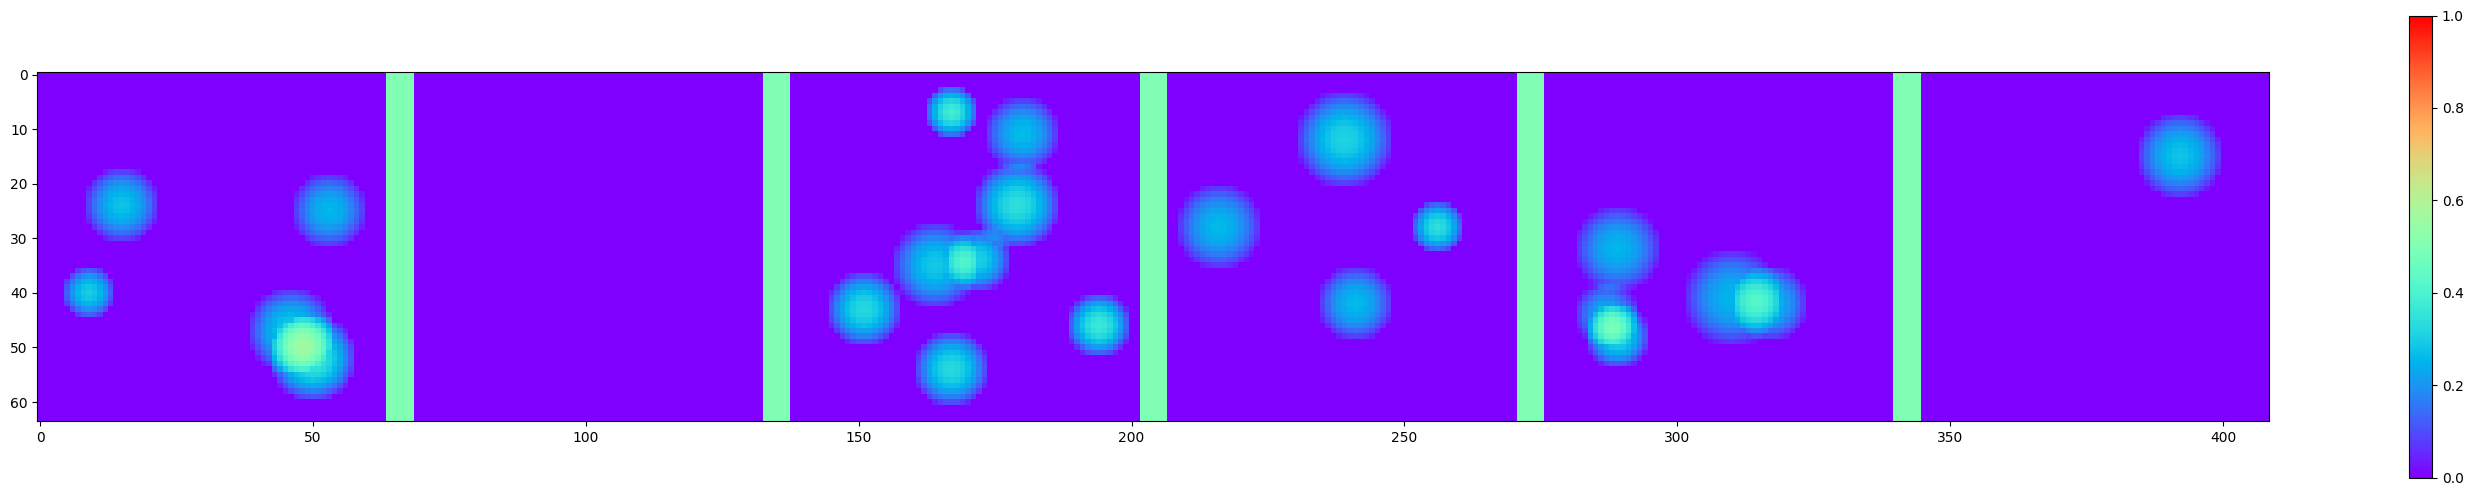

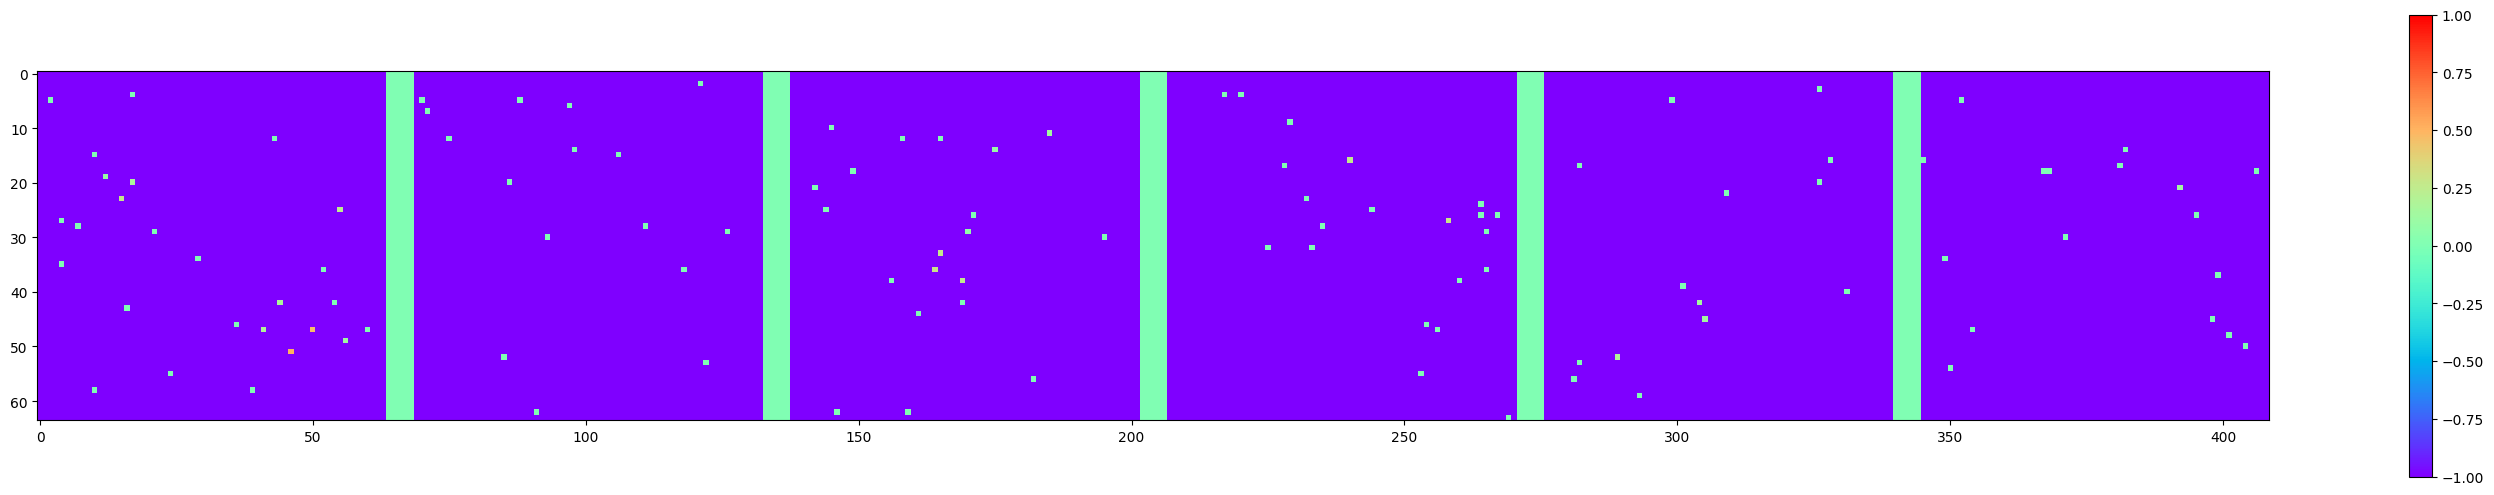

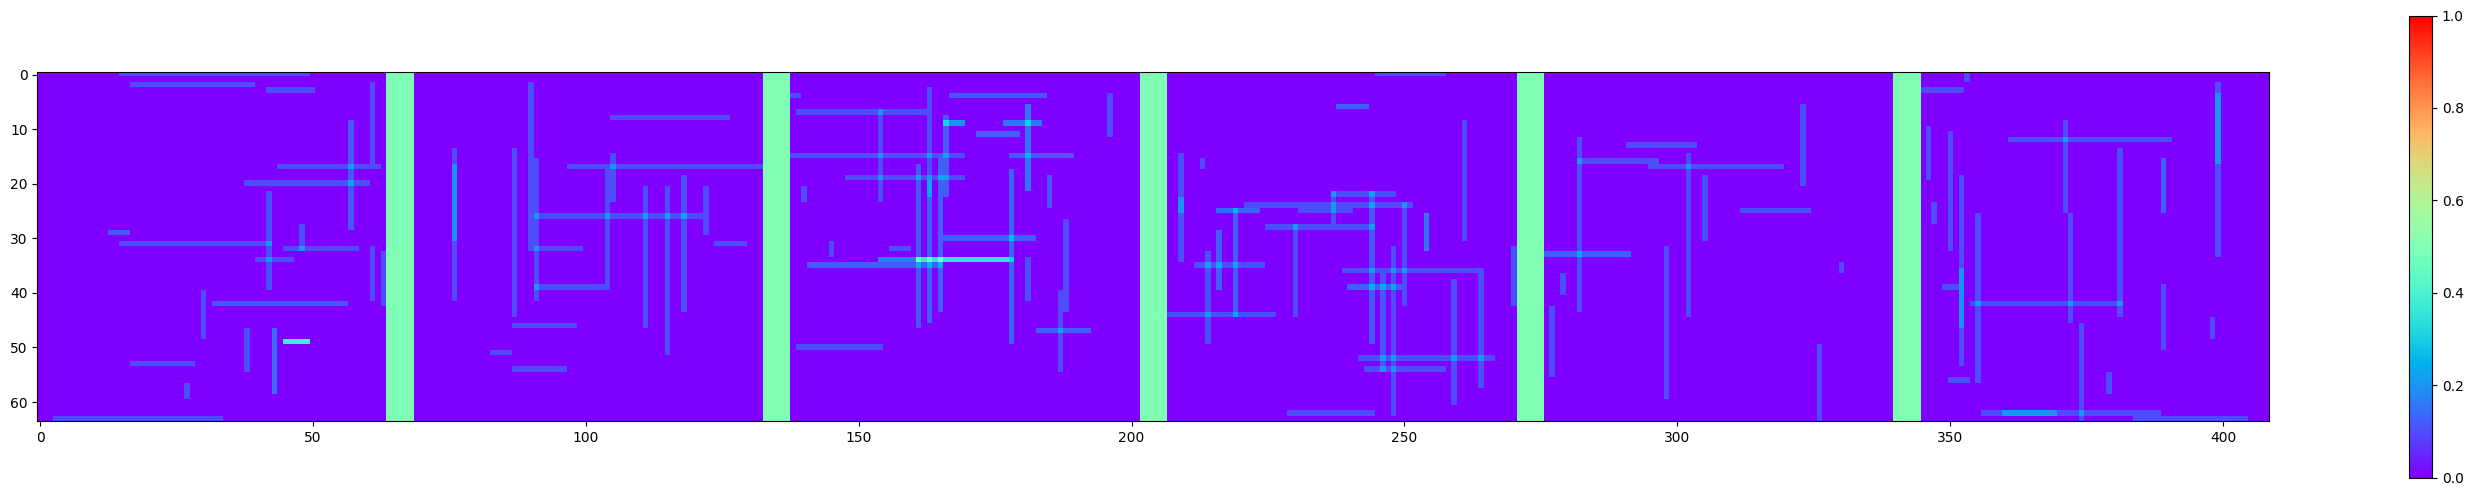

In [3]:
batch_size = 6
p = 0.5 / 100
full_target, partial_target, integrated_signals  = gen_image_with_integrated_signals(batch_size, p)


fig1 = plt.figure(1, figsize=(36, 6))
# champ T
voir_batch2D(full_target, 6, fig1, k=0, min_scale=0, max_scale=1)

# mesures ponctuelles
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(partial_target, 6, fig2, k=0, min_scale=-1, max_scale=1)

# représentation des données d'opportunité par des segments
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(integrated_signals, 6, fig3, k=0, min_scale=0, max_scale=1)

Dans la cellule précédente, la fonction *gen_image_with_integrated_signals* permet de visualiser le jeu simulé:
- *full_target* représente le champ $T$ vu par le premier type de capteur spécifique sur la zone couverte par l'image. Il s'agit de disques de valeurs positives.
- *partial_target* représente les mesures ponctuelles. En dehors des points de mesure, la valeur est fixée à -1.
- *integrated_signals* contient la représentation par segments. En dehors des segments, la valeur est fixée à 0. Dans cette simulation simpliste, les segments ont tous été supposés parallèles à l'un des deux côtés de l'image. De plus, $S$ a été modélisé comme une fonction affine, croissante de la valeur moyenne sur le segment. Ainsi, l'intensité d'un segment croit avec le nombre de disques traversés.

Dans cette partie, le but est de dire:\
**A.** si l'on peut entraîner avec succès un *FCN* à restituer $T$ **à partir** de données d'opportunité représentées par des segments (**exercice 1**).\
**B.** si en combinant des données d'opportunité aux mesures ponctuelles, on améliore bien les performances d'un $FCN$ (**exercice 2**).

**Exercice 1**

**Q1** Dans la cellule suivante, instancier un UNet. Choisir correctement *ch_in* et *ch_out*.

In [5]:
ch_in = 1
ch_out = 1
size = 8

fcn = UNet(ch_in, ch_out, size)

**Q2** Combien de poids ce réseau contient-il ? Ecrire le calcul ou intégrer un bout de code qui conduit au résultat.

In [6]:
#On determine d'abord les couches du reseau
# Pour voir les noms des couches contenues dans UNEt
for module in fcn.modules():
    print(module.__class__.__name__)

UNet
inconv
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Down
Sequential
MaxPool2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Down
Sequential
MaxPool2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Down
Sequential
MaxPool2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Down
Sequential
MaxPool2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Up
ConvTranspose2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Up
ConvTranspose2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Up
ConvTranspose2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Up
ConvTranspose2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
outconv
Conv2d
outconv
Conv2d


In [7]:


nb_weights = 0
for module in fcn.modules():
  # On compte les poids des couches qui en contiennent (attention aux doublons!):
  if isinstance(module, nn.Conv2d)\
    or isinstance(module, nn.BatchNorm2d)\
    or isinstance(module, nn.ConvTranspose2d):
    print(module.__class__.__name__)
    for parameter in module.parameters():
      nb_weights += torch.numel(parameter)
print("nb de poids : " + str(nb_weights))

Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
ConvTranspose2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
ConvTranspose2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
ConvTranspose2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
ConvTranspose2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
Conv2d
nb de poids : 232546


**Q3** Présenter brièvement les types de couches utilisées dans ce réseau.

**Q4** Dans la cellule suivante, coder en une ligne l'erreur absolue moyenne (MAE).

In [8]:
def criterion(output,target):
  return torch.mean(torch.abs(output - target))

**Q5** Instancier l'optimizer Adam avec un taux d'apprentissage de 0.0002.

In [9]:
optimizer = optim.Adam(fcn.parameters(), lr=0.001)

**Q6** Pourquoi est-il, en général, nécessaire de passer par une étape de validation lors d'un apprentissage ? Pourquoi peut-on s'en passer dans le cas où les images sont générées la volée ?

Pour garantir les performances en généralisation sur le jeu de test. Autrement dit: l'étape de validation permet de s'assurer qu'il n'y a pas surapprentissage du jeu d'entraînement.

**Q7** Ecrire la boucle d'apprentissage. On stockera la MAE à chaque époque.
- nombre d'époque : 30
- batches par époque : 100
- taille de batch : 32

In [11]:
nepochs = 30
nbatches = 100
batchsize = 32

train_losses = []


for epoch in range(nepochs):


    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):    # nbatch = datasetsize/batchsize
        #Load inputs


        full_target, partial_target, integrated_signals = gen_image_with_integrated_signals(batch_size, p)

        input = integrated_signals
        target = full_target

        #Zeroing the gradient
        optimizer.zero_grad()
        output = fcn(input)

        loss = criterion(output,target)
        loss.backward()

        optimizer.step()


        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)

    print('epoch loss : \n')
    print(epoch_loss)

Epoch 0
epoch loss : 

0.067990385
Epoch 1
epoch loss : 

0.040437926
Epoch 2
epoch loss : 

0.03659179
Epoch 3
epoch loss : 

0.03577091
Epoch 4
epoch loss : 

0.035990413
Epoch 5
epoch loss : 

0.03350555
Epoch 6
epoch loss : 

0.032580003
Epoch 7
epoch loss : 

0.032985542
Epoch 8
epoch loss : 

0.034140043
Epoch 9
epoch loss : 

0.0338768
Epoch 10
epoch loss : 

0.0321383
Epoch 11
epoch loss : 

0.032923266
Epoch 12
epoch loss : 

0.03350083
Epoch 13
epoch loss : 

0.032353308
Epoch 14
epoch loss : 

0.031483747
Epoch 15
epoch loss : 

0.03131851
Epoch 16
epoch loss : 

0.031739227
Epoch 17
epoch loss : 

0.030744337
Epoch 18
epoch loss : 

0.031084174
Epoch 19
epoch loss : 

0.030188255
Epoch 20
epoch loss : 

0.029654445
Epoch 21
epoch loss : 

0.028782243
Epoch 22
epoch loss : 

0.029884482
Epoch 23
epoch loss : 

0.029059913
Epoch 24
epoch loss : 

0.02864148
Epoch 25
epoch loss : 

0.028628236
Epoch 26
epoch loss : 

0.029839491
Epoch 27
epoch loss : 

0.029144488
Epoch 28
epo

**Q8** Visualisez les résultats. Quelle conséquence visible le choix de la fonction de coût a-t-il eu ? Conclure sur le point **A.**

**Exercice 2**

On souhaite montrer qu'un *fcn* peut utiliser simultanément les deux types de signaux (mesures ponctuelles et données d'opportunité).
Reprendre le code de **l'exercice 1** avec les deux champs en entrée. Comparer les performances aux plans quantitatif (courbes d'apprentissage) et qualitatif. Conclure.